In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt


## Parameters

In [62]:
# num harmonics
n = 14
# max frequency
w_max = 1800
# num model steps
N = 256

random_seed = 100

In [63]:
def generate_signal(n, w_max, N, max_A=1.0, print_info=True):
    """
    Generate random signal.
    
    :param int n: number of harmonics.
    :param float w_max: maximum frequency.
    :param int N: number of generation steps.
    :param float max_A: max amplitude of individual harmonics.
    :param boolean print_info: whether to print frequences,
                               amplitudes and phases of harmonics.
    :return np.ndarray result_signal: shape = (N, )
    
    """    
    w_step = w_max / n
    w = np.array([i * w_step for i in range(1, n + 1)])
    w.resize((n, 1))
    
    # generate amplitudes and phases
    amplitudes = np.random.random((n, 1)) * max_A
    phases = np.random.randint(-15, 15, size=(n, 1))
    harmonics = [np.linspace(0, N, num=N) for i in range(n)]
    harmonics = np.array(harmonics)
    
    harmonics = amplitudes * np.sin(w * harmonics + phases)
    result_signal = harmonics.sum(axis=0, keepdims=False)
    
    if print_info:
        print("Frequencies: \n", w)
        print("Amplitudes :\n", amplitudes)
        print("Phases :\n", phases)

        
    return result_signal
    

## Calculations 

In [64]:
# np.random.seed(random_seed)
signal_x = generate_signal(n, w_max, N, print_info=False)

In [65]:
%%time

mean = signal_x.mean()
print(mean)

0.020606130982470498
Wall time: 0 ns


In [66]:
%%time

dispersion = signal_x.std() ** 2
print(dispersion)

2.9553460136098577
Wall time: 0 ns


## Graphs

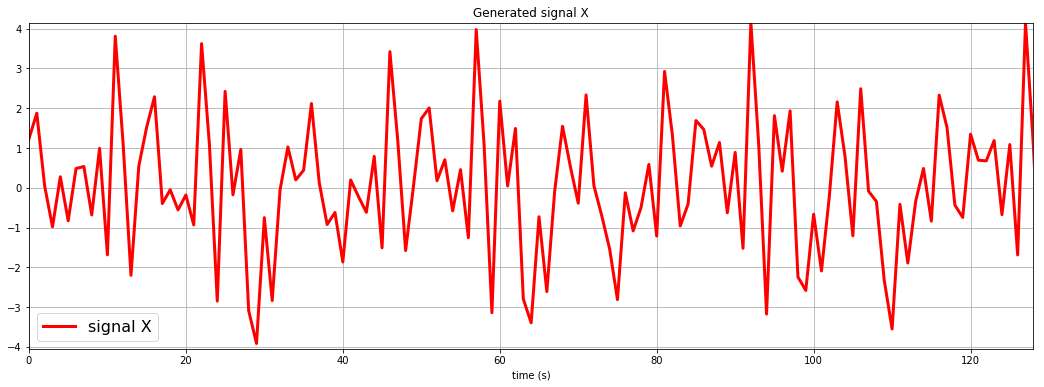

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

ax.plot(signal_x, color=(1, 0, 0), linewidth=3, ls="-")
ax.set(title="Generated signal X", xlabel="time (s)")
ax.legend(["signal X"], fontsize=16, loc=0)
ax.grid()
ax.set(xlim=[0, N/2], ylim=[signal_x.min(), signal_x.max()])

plt.show()

### Correlation

In [68]:
def correlation(signal1, signal2, tau):
    """
    :param np.ndarray signal1, signal2: 1-D arrays of equal lenght.
    :param int tau: time shift, must be less then number of gen steps.
    :return float:
    
    """
    mean1 = signal1.mean()
    mean2 = signal2.mean()
    signal1 = signal1[0: signal1.shape[0] - tau]
    signal2 = signal2[tau: ]
    
    try:
        corr = np.sum((signal1 - mean1) * (signal2 - mean2)) / (signal1.shape[0] - 1)
    except ValueError:
        print(ValueError, "Signals must have same lenght!")
        return None
    
    return corr
    
def correlation_function(signal1, signal2, tau_range):
    """
    :param np.ndaray signal1, singnal2: 1-D arrays of equal lenght.
    :param list of int tau_range:
    :return np.ndarray: 1-D array.
    
    """
    corr_func = np.zeros((len(tau_range, )))
    for i, tau in enumerate(tau_range):
        corr_func[i] = correlation(signal1, signal2, tau)
        
    return corr_func
        

### DFT

In [69]:
def dft(signal_x): 
    F = np.zeros((N, 2))
    for p in range(N):
        re, im = 0, 0
        for k in range(N):
            re += signal_x[k] * np.cos(2 * np.pi * p * k / N)
            im += signal_x[k] * np.sin(2 * np.pi * p * k / N)
        F[p, :] = (re, im)
        
    dft_x = np.sqrt(F[:, 0] ** 2 + F[:, 1] ** 2)
    return dft_x
                 

### Table DFT

In [86]:
class DFT:
    def __init__(self, N):
        """
        :param int N: Number of discrete points
        """
        self.N = N
        self.table = self.create_table(N)
    
    def create_table(self, N):
        
        W = np.zeros((N, N, 2))
        for p in range(N):
            for k in range(N):
                re = np.cos(2 * np.pi * p * k / N)
                im = np.sin(2 * np.pi * p * k / N)
                W[p, k] = (re, im) 
        return W 
    
    def dft(self, signal):
        
        F = np.zeros((N, 2))
        for p in range(N):
            re, im = 0, 0
            for k in range(N):
                re += signal[k] * self.table[p, k, 0]
                im += signal[k] * self.table[p, k, 1]
            F[p, :] = (re, im)
            
        dft_x = np.sqrt(F[:, 0] ** 2 + F[:, 1] ** 2)
        return dft_x
        

In [87]:
transformer = DFT(N)

In [88]:
dft_x = dft(signal_x)

In [89]:
dft_x2 = transformer.dft(signal_x)

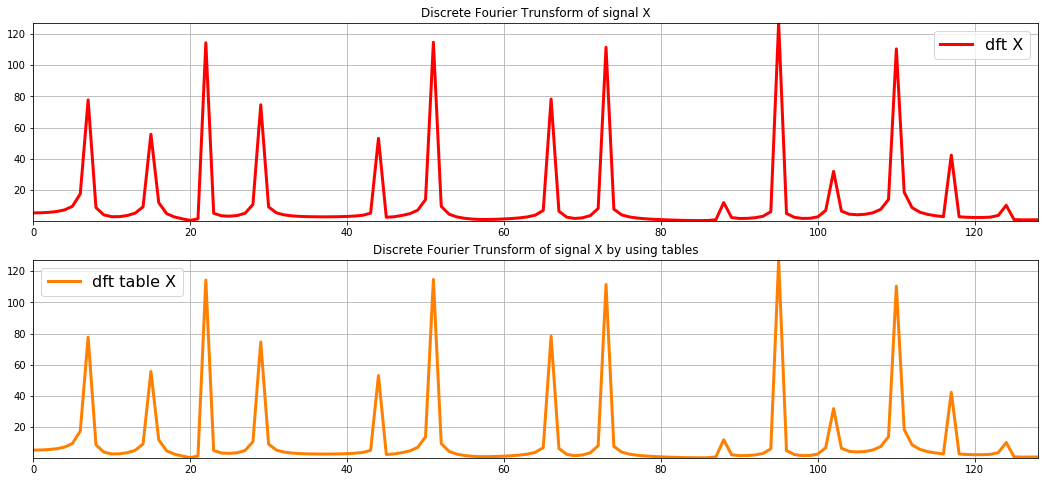

In [90]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

ax[0].plot(dft_x , color=(1, 0, 0), linewidth=3, ls="-")
ax[0].set(title="Discrete Fourier Trunsform of signal X", xlabel="")
ax[0].legend(["dft X"], fontsize=16, loc=0)
ax[0].grid()
ax[0].set(xlim=[0, N/2], ylim=[dft_x .min(), dft_x .max()])

ax[1].plot(dft_x2 , color=(1, 0.5, 0), linewidth=3, ls="-")
ax[1].set(title="Discrete Fourier Trunsform of signal X by using tables", xlabel="")
ax[1].legend(["dft table X"], fontsize=16, loc=0)
ax[1].grid()
ax[1].set(xlim=[0, N/2], ylim=[dft_x2 .min(), dft_x2 .max()])

plt.show()

### Comparison

In [79]:
transformer = DFT(N)

In [81]:
%%time

times = []
time_table = []

for i in range(0, 10):
    start_time = time.time()
    for j in range(i):
        dft_x = dft(signal_x)
    end_time = time.time()
    times.append(end_time - start_time)
    
    start_time = time.time()
    for j in range(i):
        dft_x2 = transformer.dft(signal_x)
    end_time = time.time()
    time_table.append(end_time - start_time)
    

Wall time: 25.5 s


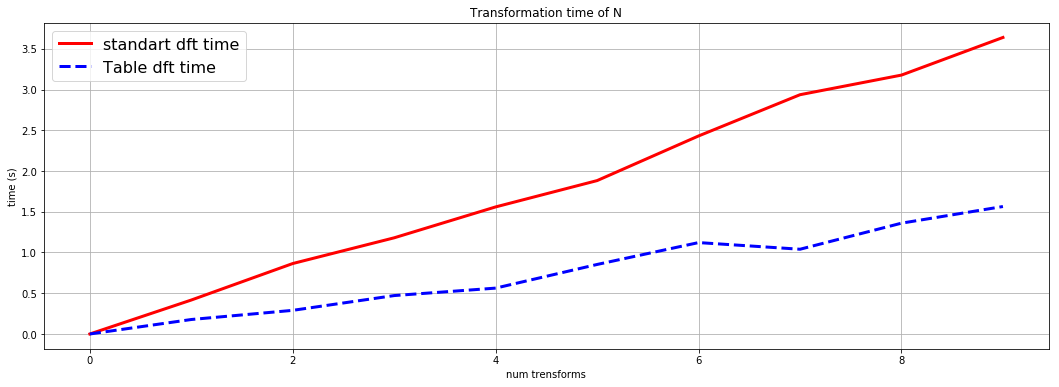

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

ax.plot(times, color=(1, 0, 0), linewidth=3, ls="-", label="standart dft time")
ax.plot(time_table, color=(0, 0, 1), linewidth=3, ls="--", label="Table dft time")
ax.set(title="Transformation time of N", xlabel="num trensforms", ylabel="time (s)")
ax.legend(fontsize=16, loc=0)
ax.grid()
#ax.set(xlim=[0, N], ylim=[signal_x.min(), signal_x.max()])

plt.show()